In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from matplotlib import pyplot as plt


In [2]:
df = pd.read_csv('data/dataset_practica_final_preprocessed.csv')
df.head()

,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,...,assigned_room_type_I,assigned_room_type_K,assigned_room_type_L,assigned_room_type_P,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,is_canceled
0,3.045939,-1.764027,0.011822,-1.676896,-0.974172,-1.278453,0.198253,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
1,7.636196,-1.764027,0.011822,-1.676896,-0.974172,-1.278453,0.198253,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
2,-0.847064,-1.764027,0.011822,-1.676896,-0.974172,-0.791496,-1.397925,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
3,-0.777338,-1.764027,0.011822,-1.676896,-0.974172,-0.791496,-1.397925,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0
4,-0.765717,-1.764027,0.011822,-1.676896,-0.974172,-0.304540,0.198253,-0.304108,-0.095288,-0.201653,...,False,False,False,False,False,False,False,True,False,0


In [3]:
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [9]:
# Modelo base
# model_xgb = xgb.XGBClassifier(random_state=42)
model_xgb = xgb.XGBClassifier(random_state=42,objective="binary:logistic",
                 eval_metric="logloss",
                 tree_method="hist",
                 )

In [11]:
param_dist = {
    'n_estimators':     [200, 300, 400],
    'max_depth':        [4, 6, 8],
    'learning_rate':    [0.01, 0.05, 0.1],
    'subsample':        [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma':            [0, 0.1, 0.2]
}

random_search = RandomizedSearchCV(
    estimator=model_xgb,
    param_distributions=param_dist,
    n_iter=5,
    cv=2,
    scoring='f1',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print("\nMejores hiperparámetros encontrados:")
print(random_search.best_params_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits

Mejores hiperparámetros encontrados:
{'subsample': 1.0, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}


In [14]:
best_model = random_search.best_estimator_
model_xgb = best_model
model_xgb

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [15]:
y_pred  = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

In [16]:
# Obtención de las métricas de evaluación
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Cálculo del AUC (Area Under the Curve)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy:  {acc:.2f}")
print(f"Precisión: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-Score:  {f1:.2f}")
print(f"AUC:       {auc:.2f}\n")

Accuracy:  0.85
Precisión: 0.76
Recall:    0.68
F1-Score:  0.72
AUC:       0.92



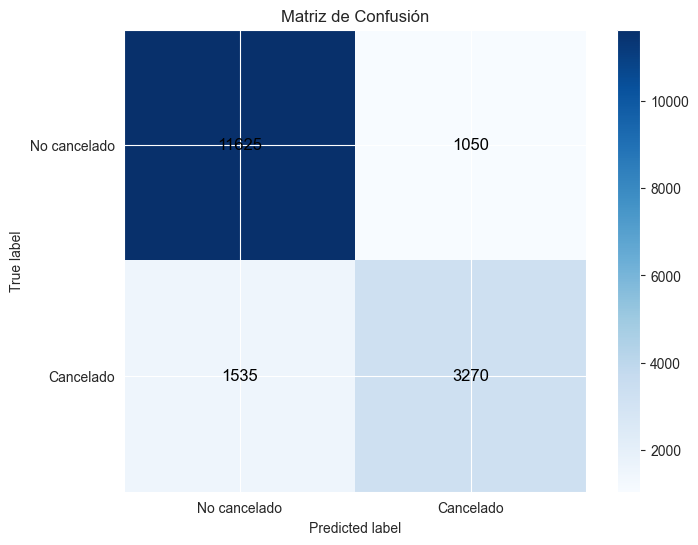

In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No cancelado', 'Cancelado'])
disp.plot(cmap='Blues', ax=plt.gca(), colorbar=True)

for texts in disp.text_.ravel():
    texts.set_color('black')
    texts.set_fontsize(12)
plt.title('Matriz de Confusión')
plt.show()

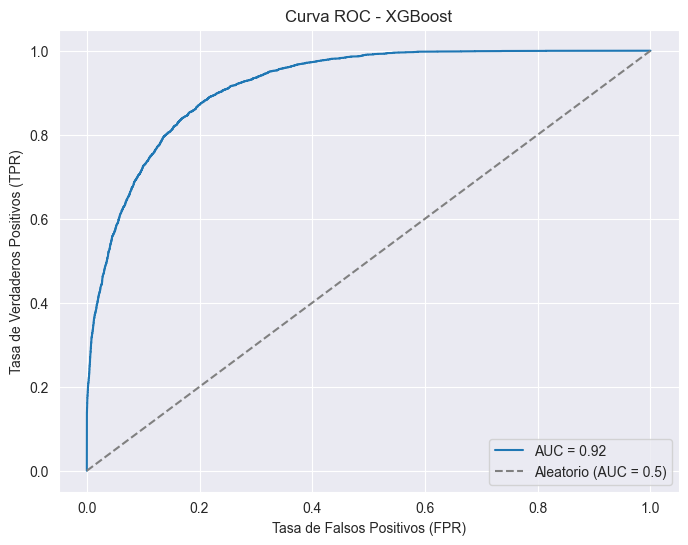

In [21]:
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Aleatorio (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - XGBoost')
plt.legend()
plt.show()